## Update a Wflow model: gauging stations

Once you have a **Wflow** model, you may want to update your model in order to use a new landuse map, change a parameter value, add sample locations, use different forcing data, create and run different scenarios etc.

With HydroMT, you can easily read your model and update one or several components of your model using the **update** function of the command line interface (CLI). Here are the steps and some examples on how to **update/add gauging stations** to your model.

All lines in this notebook which starts with ! are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste them in your shell to get more feedback.

### Import packages

In this notebook, we will use some functions of HydroMT to plot the new gauging stations of the updated model. Here are the libraries to import to realize these steps.

In [1]:
import numpy as np
import hydromt

In [2]:
# for plotting
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()  # plot projection

### Locations of the gauging stations

Adding gauging stations to your **Wflow** model can be quite useful. It allows you to directly extract model outputs at specific locations. For example for model validation, calibration, you can then directly compare model results to available observations.

In our previous notebook, we built a wflow model in which the locations of the available [GRDC](https://www.bafg.de/GRDC/EN/Home/homepage_node.html) stations are including. If you have other observation data available, you can easily add them to your model using HydroMT. One way to do it is to prepare a csv table containing the ID, latitude and longitude of the available stations. An example **test_stations.csv** has been prepared. Let's have a look at it. 

In [3]:
fn_station = "test_stations.csv"
with open(fn_station, "r", encoding="utf8") as f:
    txt = f.read()
print(txt)

﻿ID,Name,x,y,uparea
1001,Gauge1,11.9594,45.8925,3642
1002,Gauge2,12.3395,46.1492,2
1003,Gauge3,12.0785,46.1122,837



Here we can see that we have defined three stations with an ID and the longitude (x) and latitude (y) coordinates, in the same EPSG system as our model (EPSG 4326). We can now add them to our model.

### HydroMT CLI update interface

Using the **HydroMT build** API, we can update one or several components of an already existing Wflow model. Let's get an overview of the available options:

In [4]:
# Print the options available from the update command
! hydromt update --help

Usage: hydromt update [OPTIONS] MODEL MODEL_ROOT

  Update a specific component of a model.

  Set an output directory to copy the edited model to a new folder, otherwise
  maps are overwritten.

  Example usage: --------------

  Update (overwrite!) landuse-landcover based maps in a Wflow model: hydromt
  update wflow /path/to/model_root -c setup_lulcmaps --opt lulc_fn=vito -d
  /path/to/data_catalog.yml -v

  Update Wflow model components outlined in an .yml configuration file and
  write the model to a directory: hydromt update wflow /path/to/model_root  -o
  /path/to/model_out  -i /path/to/wflow_config.yml  -d
  /path/to/data_catalog.yml -v

Options:
  -o, --model-out DIRECTORY  Output model folder. Maps in MODEL_ROOT are
                             overwritten if left empty.
  -i, --config PATH          Path to hydroMT configuration file, for the model
                             specific implementation.
  -c, --components TEXT      Model methods from configuration file to run
 

### Update Wflow gauging stations

In [5]:
# NOTE: copy this line (without !) to your shell for more direct feedback
! hydromt update wflow wflow_piave_subbasin -o ./wflow_piave_gauges -c setup_gauges --opt gauges_fn=test_stations.csv --opt basename=test-flow -v

2025-04-09 16:17:29,956 - update - log - INFO - HydroMT version: 0.10.1
2025-04-09 16:17:29,956 - update - main - INFO - Updating wflow model at C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_subbasin (r).
2025-04-09 16:17:29,956 - update - main - INFO - Output dir: C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_gauges
2025-04-09 16:17:29,956 - update - main - INFO - User settings:
2025-04-09 16:17:30,446 - update - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.8.0).
2025-04-09 16:17:30,446 - update - data_catalog - INFO - Parsing data catalog from C:\code\py_dev\hydromt_wflow\hydromt_wflow\data\parameters_data.yml
2025-04-09 16:17:30,466 - update - wflow - INFO - Read grid from C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_subbasin\staticmaps.nc
2025-04-09 16:17:30,820 - update - wflow - INFO - Reading model staticgeom files.
2025-04-09 16:17:30,879 - update - wflow - INFO - Read forcing from C:\code\py_dev\hydromt_wflow\docs\_examples\

The example above means the following: run **hydromt** with:

- `update wflow`: i.e. update a wflow model
- `wflow_piave_subbasin`: original model folder
- `-o ./wflow_piave_gauges`: output updated model folder
- `-c setup_gauges`: model component to update, here setup_gauges to add gauging stations
- `--opt gauges_fn=test_stations.csv`: name in hydromt data catalog or path to a csv file containing the gauges locations
- `--opt basename=test-flow`: name of the new gauges map in the staticmaps of Wflow
- `v`: give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

Other available options are available in the [docs (setup gauges)](https://deltares.github.io/hydromt_wflow/latest/_generated/hydromt_wflow.WflowModel.setup_gauges.html).

### Update Wflow gauging stations without snapping

By default, the **setup_gauges** of HydroMT Wflow will assume that gauges are for flow sampling and will therefore snap the gauges locations to the river. If your observations are used to compare rainfall data, then you do not want HydroMT to move the location of your gauges. This is done by setting `--opt snap_to_river=False`.

By default, HydroMT Wflow will update the TOML in order to save both river discharge and precipitation at the new gauges locations. With our rainfall stations, we only need to save the precipitation. We can set this with hydroMT using the options:

- `--opt gauge_toml_header="['P-station']"`: set the column name in the outputcsv file of the Wflow run in the TOML configuration
- `--opt gauge_toml_param="['vertical.precipitation']"`: set the Wflow variable to save in the corresponding outputcsv file column of Wflow run in the TOML configuration 

In [6]:
# NOTE: copy this line (without !) to your shell for more direct feedback
! hydromt update wflow wflow_piave_gauges -c setup_gauges --opt gauges_fn=test_stations.csv --opt basename=test-rain --opt snap_to_river=False --opt gauge_toml_header="['P-station']" --opt gauge_toml_param="['vertical.precipitation']" -v

2025-04-09 16:17:38,704 - update - log - INFO - HydroMT version: 0.10.1
2025-04-09 16:17:38,704 - update - main - INFO - Updating wflow model at C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_gauges (r+).
2025-04-09 16:17:38,704 - update - main - INFO - Output dir: C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_gauges
2025-04-09 16:17:38,704 - update - main - INFO - User settings:
2025-04-09 16:17:39,176 - update - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.8.0).
2025-04-09 16:17:39,176 - update - data_catalog - INFO - Parsing data catalog from C:\code\py_dev\hydromt_wflow\hydromt_wflow\data\parameters_data.yml
2025-04-09 16:17:39,198 - update - wflow - INFO - Reading model staticgeom files.
2025-04-09 16:17:39,204 - update - wflow - INFO - Read grid from C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_gauges\staticmaps.nc
2025-04-09 16:17:39,620 - update - model_api - INFO - setup_gauges.gauges_fn: test_stations.csv
2025-04-09 16:17:39

The example above means the following: run **hydromt** with:

- `update wflow`: i.e. update a wflow model
- `wflow_piave_gauges`: model folder to update (here we save our updates in the same model folder)
- `-c setup_gauges`: model component to update, here setup_gauges to add gauging stations
- `--opt gauges_fn=test_stations.csv`: name in hydromt data catalog or path to a csv file containing the gauges locations
- `--opt basename=test-rain`: name of the new gauges map in the staticmaps of Wflow
- `--opt snap_to_river=False`
- `--opt gauge_toml_header="['P-station']"`: set the column name in the outputcsv file of the Wflow run in the TOML configuration
- `--opt gauge_toml_param="['vertical.precipitation']"`: set the Wflow variable to save in the corresponding outputcsv file column of Wflow run in the TOML configuration 
- `v`: give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

Other available options are available in the [docs (setup gauges)](https://deltares.github.io/hydromt_wflow/latest/_generated/hydromt_wflow.WflowModel.setup_gauges.html).

Note: when changing several options, the command line can get quite long. You can also create a HydroMT configuration file where you set all the different options and use it in your command line with the `-i` argument instead of `-c` and several `--opt`

### Visualization of the gauges

We can now plot our newly created gauges stations maps and check the differences between the flow and rain maps.

In [7]:
# Load the updated model with hydromt
from hydromt_wflow import WflowModel

mod = WflowModel(root="wflow_piave_gauges", mode="r")

In [8]:
# read/derive river geometries
gdf_riv = mod.rivers
# read/derive model basin boundary
gdf_bas = mod.basins

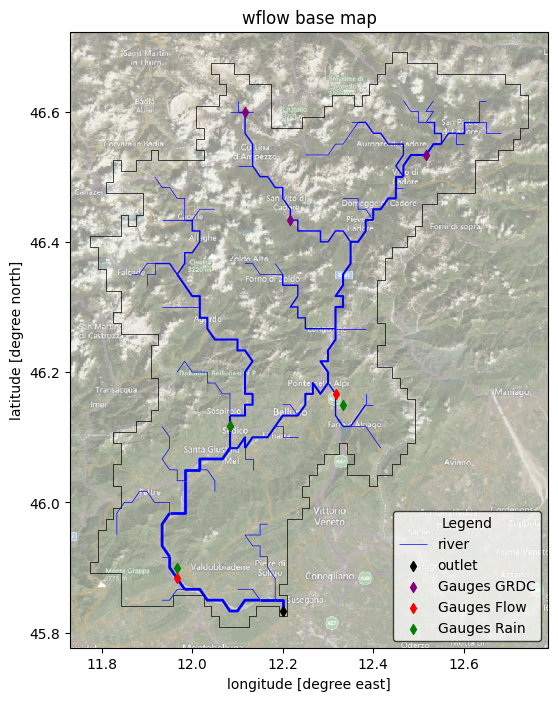

In [9]:
# Plot
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
bbox = mod.grid.raster.box.to_crs(3857).buffer(5e3)
extent = np.array(bbox.to_crs(mod.grid.raster.crs).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

# plot rivers with increasing width with stream order
gdf_riv.plot(ax=ax, lw=gdf_riv["strord"] / 2, color="blue", zorder=3, label="river")
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color="k", linewidth=0.5)

if "gauges" in mod.geoms:
    mod.geoms["gauges"].plot(
        ax=ax, marker="d", markersize=25, facecolor="k", zorder=5, label="outlet"
    )
if "gauges_grdc" in mod.geoms:
    mod.geoms["gauges_grdc"].plot(
        ax=ax,
        marker="d",
        markersize=25,
        facecolor="purple",
        zorder=5,
        label="Gauges GRDC",
    )
if "gauges_test-flow" in mod.geoms:
    mod.geoms["gauges_test-flow"].plot(
        ax=ax, marker="d", markersize=25, facecolor="red", zorder=5, label="Gauges Flow"
    )
if "gauges_test-rain" in mod.geoms:
    mod.geoms["gauges_test-rain"].plot(
        ax=ax,
        marker="d",
        markersize=25,
        facecolor="green",
        zorder=5,
        label="Gauges Rain",
    )

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"wflow base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0]],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)